# Window Splitters in aeon

In this notebook we describe the window splitters included in the [aeon.forecasting.model_selection](https://github.com/aeon-toolkit/aeon/blob/main/aeon/forecasting/model_selection/_split.py) module. These splitters can be combined with `ForecastingGridSearchCV` for model selection (see [forecasting notebook](forecasting.ipynb)).

**Remark:** It is important to emphasize that for cross-validation in time series we can not randomly shuffle the data as we would be leaking information.

**References:**
- [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)
- [Cross-validation for time series](https://robjhyndman.com/hyndsight/tscv/)

## Preliminaries

In [1]:
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

from aeon.datasets import load_airline
from aeon.forecasting.base import ForecastingHorizon
from aeon.forecasting.model_selection import (
    CutoffSplitter,
    ExpandingWindowSplitter,
    SingleWindowSplitter,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from aeon.visualisation import plot_series

In [2]:
def plot_windows(y, train_windows, test_windows, title=""):
    """Visualize training and test windows"""

    simplefilter("ignore", category=UserWarning)

    def get_y(length, split):
        # Create a constant vector based on the split for y-axis."""
        return np.ones(length) * split

    n_splits = len(train_windows)
    n_timepoints = len(y)
    len_test = len(test_windows[0])

    train_color, test_color = sns.color_palette("colorblind")[:2]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.3))

    for i in range(n_splits):
        train = train_windows[i]
        test = test_windows[i]

        ax.plot(
            np.arange(n_timepoints), get_y(n_timepoints, i), marker="o", c="lightgray"
        )
        ax.plot(
            train,
            get_y(len(train), i),
            marker="o",
            c=train_color,
            label="Window",
        )
        ax.plot(
            test,
            get_y(len_test, i),
            marker="o",
            c=test_color,
            label="Forecasting horizon",
        )
    ax.invert_yaxis()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title=title,
        ylabel="Window number",
        xlabel="Time",
        xticklabels=y.index,
    )
    # remove duplicate labels/handles
    handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
    ax.legend(handles, labels)

## Data

We use a fraction of the Box-Jenkins univariate airline data set, which shows the number of international airline passengers per month from 1949 - 1960.

In [3]:
# We are interested on a portion of the total data set.
# (for visualisatiion purposes)
y = load_airline().iloc[:30]
y.head()

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
Freq: M, Name: Number of airline passengers, dtype: float64

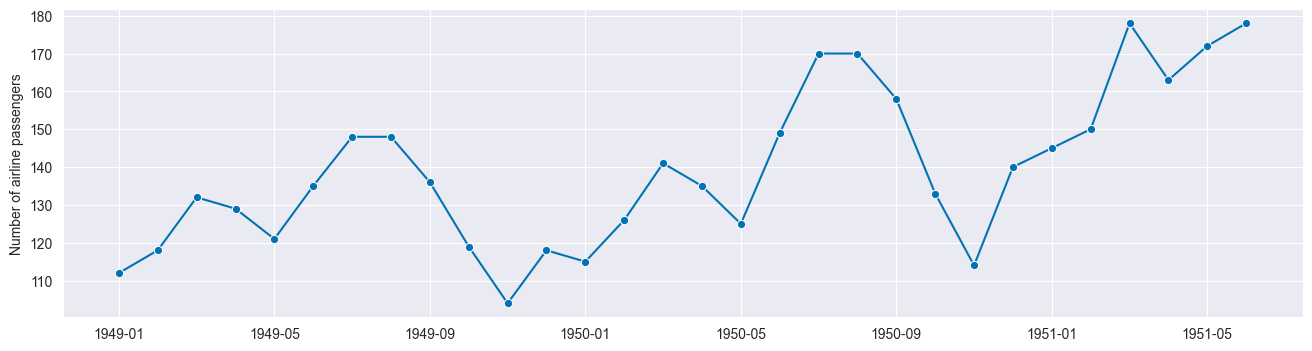

In [4]:
fig, ax = plot_series(y)

## Visualizing temporal cross-validation window splitters

Now we describe each of the splitters.

### A single train-test split using `temporal_train_test_split`

This one splits the data into training and test sets. You can either (i) set the size of the training or test set or (ii) use a forecasting horizon.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

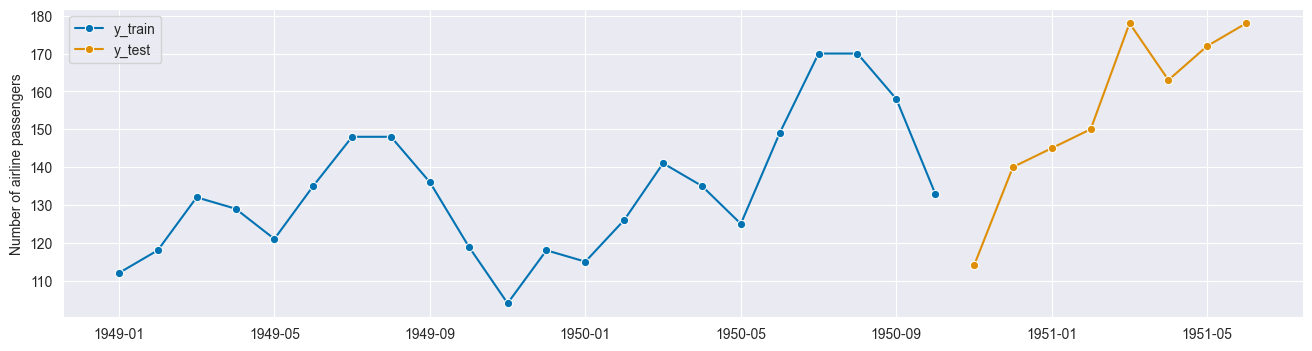

In [5]:
# setting test set size
y_train, y_test = temporal_train_test_split(y=y, test_size=0.25)
plot_series(y_train, y_test, labels=["y_train", "y_test"])

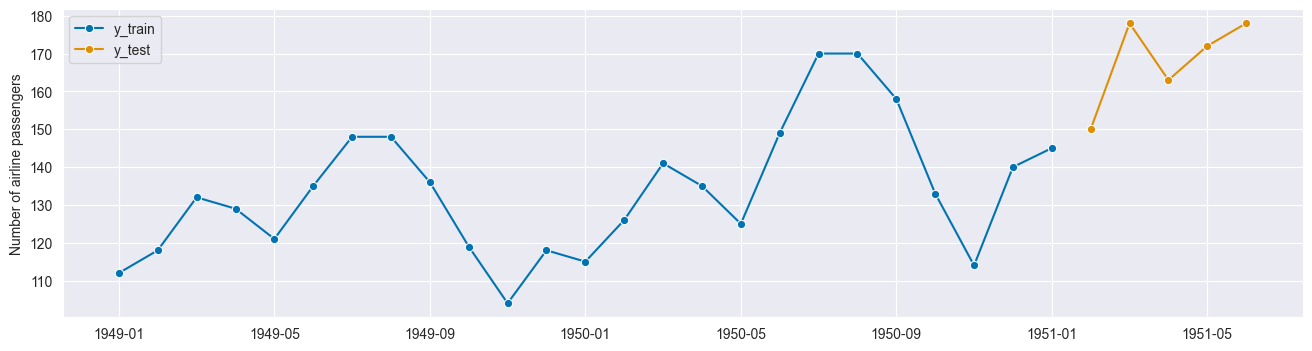

In [6]:
# using forecasting horizon
fh = ForecastingHorizon([1, 2, 3, 4, 5])
y_train, y_test = temporal_train_test_split(y, fh=fh)
plot_series(y_train, y_test, labels=["y_train", "y_test"]);

### Single split using `SingleWindowSplitter`

This class splits the time series once into a training and test window. Note that this is very similar to `temporal_train_test_split`.

Let us define the parameters of our fold:

In [7]:
# set splitter parameters
window_length = 5
fh = ForecastingHorizon([1, 2, 3])

In [8]:
cv = SingleWindowSplitter(window_length=window_length, fh=fh)
n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 1


Let us plot the unique fold generated. First we define some helper functions:

In [9]:
def get_windows(y, cv):
    """Generate windows"""
    train_windows = []
    test_windows = []
    for i, (train, test) in enumerate(cv.split(y)):
        train_windows.append(train)
        test_windows.append(test)
    return train_windows, test_windows

Now we generate the plot:

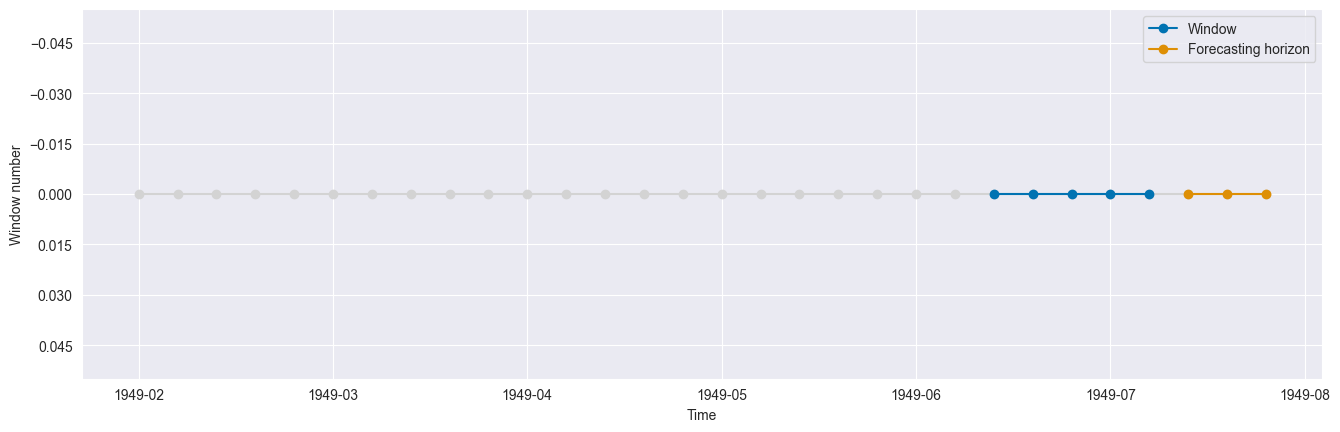

In [10]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

In [11]:
test_windows

[array([27, 28, 29])]

In [12]:
train_windows

[array([22, 23, 24, 25, 26], dtype=int64)]

### Sliding windows using `SlidingWindowSplitter`

This splitter generates folds which move with time. The length of the training and test sets for each fold remains constant.

In [13]:
cv = SlidingWindowSplitter(window_length=window_length, fh=fh)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 23


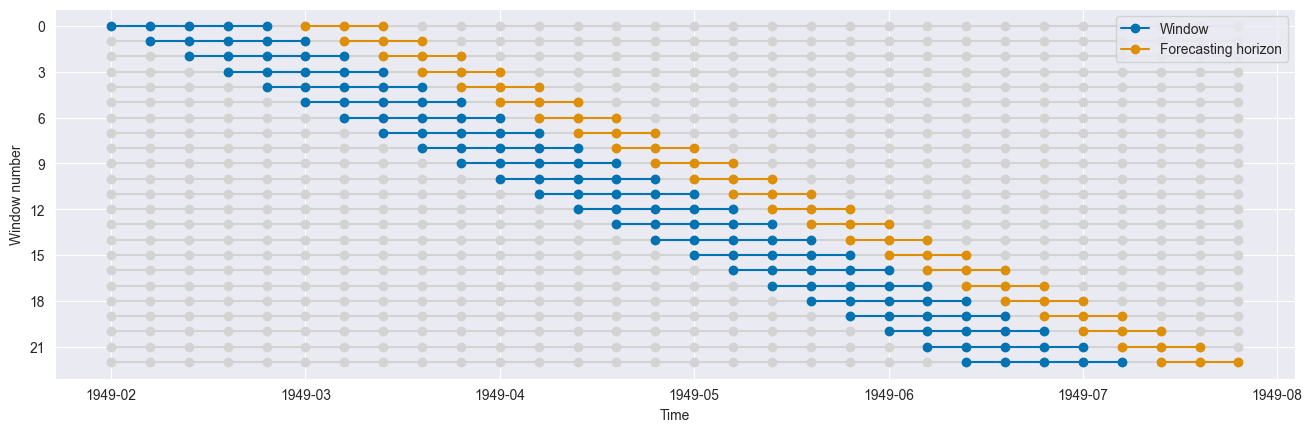

In [14]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

### Sliding windows using `SlidingWindowSplitter` with an initial window

This splitter generates folds which move with time. The length of the training and test sets for each fold remains constant.

In [15]:
cv = SlidingWindowSplitter(window_length=window_length, fh=fh, initial_window=10)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 18


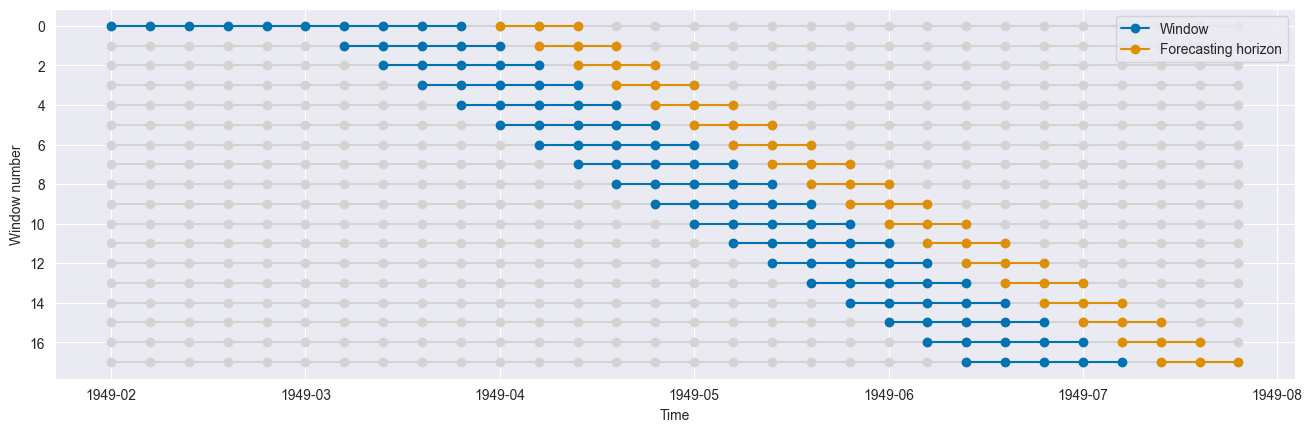

In [16]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

### Expanding windows using `ExpandingWindowSplitter`

This splitter generates folds which move with time. The length of the training set each fold grows while test sets for each fold remains constant.

In [17]:
cv = ExpandingWindowSplitter(initial_window=window_length, fh=fh)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 23


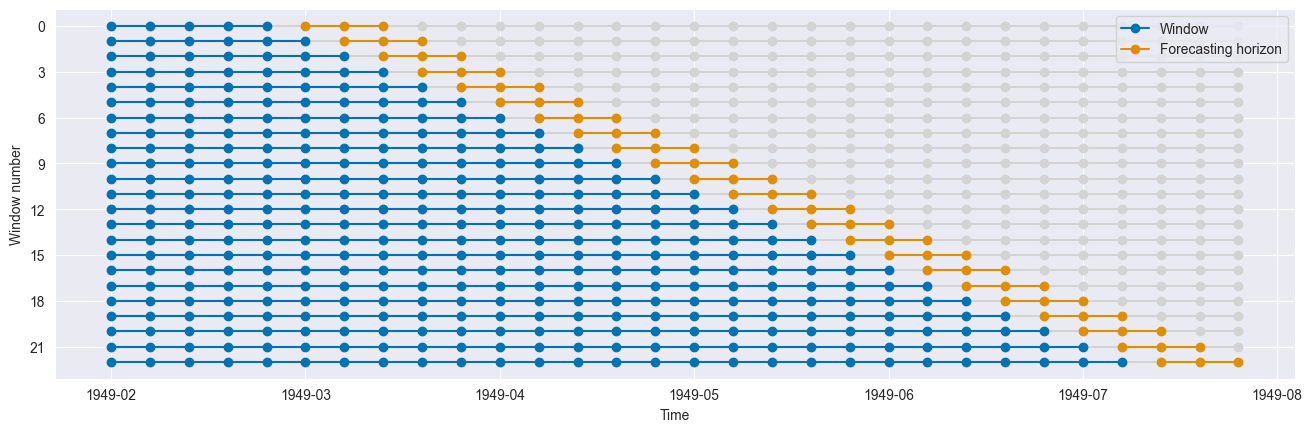

In [18]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

### Multiple splits at specific cutoff values - `CutoffSplitter`

With this splitter we can manually select the cutoff points.

In [19]:
# Specify cutoff points (by array index).
cutoffs = np.array([10, 13, 15, 25])

cv = CutoffSplitter(cutoffs=cutoffs, window_length=window_length, fh=fh)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 4


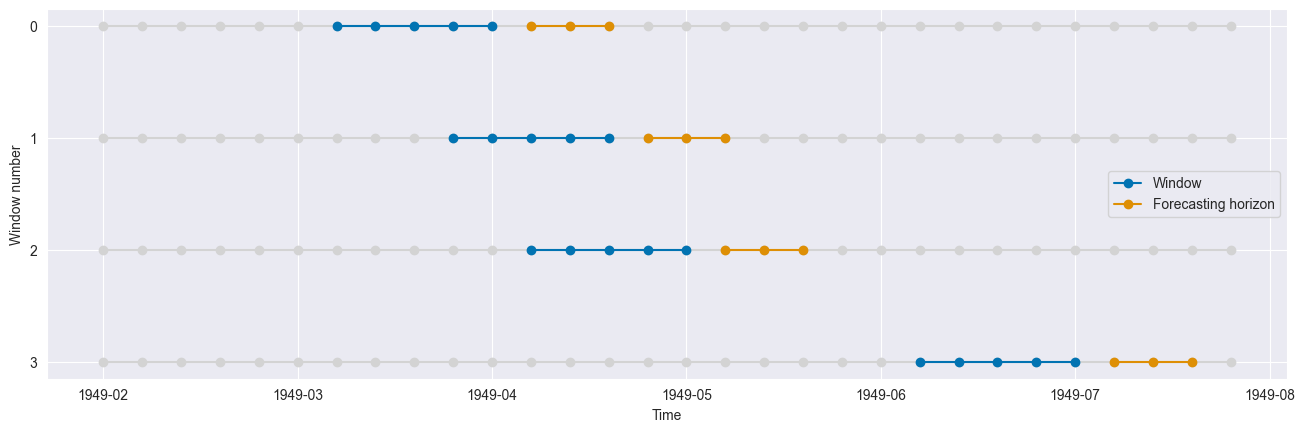

In [20]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

In [21]:
train_windows

[array([ 6,  7,  8,  9, 10], dtype=int64),
 array([ 9, 10, 11, 12, 13], dtype=int64),
 array([11, 12, 13, 14, 15], dtype=int64),
 array([21, 22, 23, 24, 25], dtype=int64)]

In [22]:
test_windows

[array([11, 12, 13]),
 array([14, 15, 16]),
 array([16, 17, 18]),
 array([26, 27, 28])]